In [40]:
import subprocess
import numpy as np
import pandas as pd

import matplotlib

from datetime import datetime

pd.set_option('display.max_rows', 500)

![CRSIP_DM](..\reports\figures\CRISP_DM.png)

# Data Preparation

* focus on understanding the final data structure
* support each step by visual analytics

## John Hopkins github CSV data

In [3]:
git_pull = subprocess.Popen( "git pull" , 
                     cwd = os.path.dirname( '../data/raw/COVID-19/' ), 
                     shell = True, 
                     stdout = subprocess.PIPE, 
                     stderr = subprocess.PIPE )
(out, error) = git_pull.communicate()


print("Error : " + str(error)) 
print("out : " + str(out))

Error : b'From https://github.com/CSSEGISandData/COVID-19\n   382e42db..89fbfba8  master                 -> origin/master\n * [new branch]        2944-Fix-Spain-July-27 -> origin/2944-Fix-Spain-July-27\n * [new branch]        Fix-Idaho-July-25      -> origin/Fix-Idaho-July-25\n * [new branch]        Update-Peru-July-29    -> origin/Update-Peru-July-29\n   fb5839dc..ee45499b  web-data               -> origin/web-data\n'
out : b'Updating 382e42db..89fbfba8\nFast-forward\n README.md                                          |    3 +-\n csse_covid_19_data/README.md                       |    6 +-\n csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv   |    1 +\n .../csse_covid_19_daily_reports/07-26-2020.csv     | 3932 ++++++++++++\n .../csse_covid_19_daily_reports/07-27-2020.csv     | 3932 ++++++++++++\n .../csse_covid_19_daily_reports/07-28-2020.csv     | 3933 ++++++++++++\n .../csse_covid_19_daily_reports_us/07-26-2020.csv  |   59 +\n .../csse_covid_19_daily_reports_us/07-27-2020.csv  |   5

In [4]:


data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path)

In [6]:
pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,880,884,884,889,889,897,897,897,907,907
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,705,749,779,812,851,880,916,932,950,1000


In [9]:
time_index = pd_raw.columns[4:]

In [34]:
df_plot = pd.DataFrame({
    'date': time_index
})
df_plot.head()

,date
0,1/22/20
1,1/23/20
2,1/24/20
3,1/25/20
4,1/26/20


In [35]:
type(df_plot['date'][0])

str

In [19]:
country_set = pd_raw['Country/Region'].unique()

In [20]:
country_set

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [23]:
pd_raw[pd_raw['Country/Region'] == 'US'].iloc[:, 4::].sum(axis=0)

1/22/20    1
1/23/20    1
1/24/20    2
1/25/20    2
dtype: int64

In [31]:
limited_country_list = ['Italy', 'Korea, South', 'Germany', 'Spain', 'US']

In [36]:
for country in limited_country_list:
    df_plot[country] = np.array(pd_raw[pd_raw['Country/Region'] == country].iloc[:, 4::].sum(axis=0))

In [37]:
df_plot.head()

,date,Italy,"Korea, South",Germany,Spain,US
0,1/22/20,0,1,0,0,1
1,1/23/20,0,1,0,0,1
2,1/24/20,0,2,0,0,2
3,1/25/20,0,2,0,0,2
4,1/26/20,0,3,0,0,5


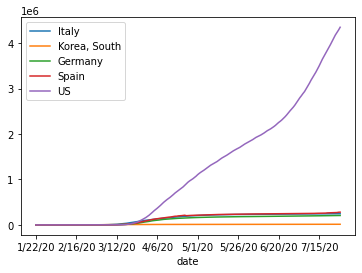

In [39]:
df_plot.set_index('date').plot()

## Data Type Date

In [44]:
time_index= [datetime.strptime(each, '%m/%d/%y') for each in df_plot.date]
time_string_iso = [each.strftime('%Y-%m-%d') for each in time_index]

In [45]:
df_plot['date'] = time_index

In [46]:
df_plot.head()

,date,Italy,"Korea, South",Germany,Spain,US
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,3,0,0,5


In [47]:
df_plot.to_csv('../data/processed/COVID_small_flat_table_July 29_.csv', sep = ';')